In [1]:
#imports
import pandas as pd
import numpy as np
import wfdb 
import matplotlib.pyplot as plt
import seaborn as sns
from wfdb.processing import resample_singlechan,resample_ann
import pickle
from sklearn.preprocessing import StandardScaler
from matplotlib import colors
from scipy.stats import norm

#%matplotlib notebook


In [2]:
#Matplotlib settings
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [3]:
def data_from_records(records,channel, db,anntype):
    """
    Extract ECG MIT-BH Physionet database.
    Takes a list of record names, ECG channel index and name of the
    PhysioNet database. Tested only with db == 'afdb'.
    Parameters
    ----------
    records : list
        list of file paths to the wfdbdb-records
    channel : int
        ECG channel that is wanted from each record
    db : string
        Name of the PhysioNet ECG database
    anntype : string
        Type of annotation file
    Returns
    -------
    signals : list
        list of single channel ECG records stored as numpy arrays
    R_peaks: list
        list of R peaks locations for each ECG signal
    """
    signals = []
    r_peaks = []
    
    for record in records:
        print('processing record: ', record)
        signal = (wfdb.io.rdsamp(record,pn_dir=db)) #reading sample
        signal_fs = signal[1]['fs'] #fetching sampling frequency of Signal
        ann = wfdb.rdann(record, anntype, pn_dir=db) #reading annotation files for R_peak locations
        signal= signal[0][:, channel] #Storing only given single channel. 
        
        annotation = wfdb.rdann(record, anntype, pn_dir=db) #reading QRS annotation files for R_peak locations
        
        signals.append(signal) #appending signals.
        r_peaks.append(annotation)#appending annotations. 

    return signals, r_peaks , signal_fs




In [4]:
def resample_signals(signals,annotations,signal_fs,target_fs):
    """
    Resamples the signal and annotation to required sampling rate
    ----------
    signals : list
        list of wfdb signals
    annotations: list
        list of wfdb annotations
    signal_fs : int
        current sampling rate
    target_fs : int
        target sampling rate 
    Returns
    -------
    resampled_signals : list
        list of single channel ECG records stored with target sampling rate
    resampled_annotations : list
        list of single channel ECG annotations stored with target sampling rate
    fs: int
        target sampling rate
    """
    resampled_signals=[]
    resampled_annotations=[]
    for sig,ann in zip(signals,annotations):
        
        signal, annotation = resample_singlechan(
                                sig,
                                ann,
                                fs=signal_fs,
                                fs_target=target_fs)
        resampled_signals.append(signal)
        resampled_annotations.append(annotation)
    return resampled_signals,resampled_annotations,target_fs


#### Loading MIT-BH Atrial Fibbrillation Records from Physio-Net #sampling rate = 250
##### This database includes 25 long-term ECG recordings of human subjects with atrial fibrillation (mostly paroxysmal). Of these, 23 records include the two ECG signals (in the .dat files); records 00735 and 03665 are represented only by the rhythm (.atr) and unaudited beat (.qrs annotation files.

In [5]:
#Get all record names from MIT-BH AFIB Database to load the Raw ECG Signals. 
afdb_records = wfdb.io.get_record_list('afdb')

#Removing samples that are corrupted in database. 
afdb_records.remove('00735')
afdb_records.remove('03665')


#Function to read data (Takes records name, channel, name of db)
afdb_signals,r_peaks_afdb,afdb_fs = data_from_records(afdb_records, channel=0, db='afdb',anntype='qrs')

/Users/asim/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


processing record:  04015
processing record:  04043
processing record:  04048
processing record:  04126
processing record:  04746
processing record:  04908
processing record:  04936
processing record:  05091
processing record:  05121
processing record:  05261
processing record:  06426
processing record:  06453
processing record:  06995
processing record:  07162
processing record:  07859
processing record:  07879
processing record:  07910
processing record:  08215
processing record:  08219
processing record:  08378
processing record:  08405
processing record:  08434
processing record:  08455


#### Loading MIT-BH Normal Sinus Rythem Records from Physio-Net #Sampling Rate- 128

##### This database includes 18 long-term ECG recordings of subjects referred to the Arrhythmia Laboratory at Boston's Beth Israel Hospital (now the Beth Israel Deaconess Medical Center). Subjects included in this database were found to have had no significant arrhythmias; they include 5 men, aged 26 to 45, and 13 women, aged 20 to 50

In [11]:
#Get all record names from MIT-BH Normal Sinus Rythem (NSRDB) Database to load the Raw ECG Signals. 
nsrdb_records = wfdb.io.get_record_list('nsrdb')
ns_signals,r_peaks_ns,ns_fs = data_from_records(nsrdb_records, channel=0, db='nsrdb',anntype='atr')



processing record:  16265
processing record:  16272
processing record:  16273
processing record:  16420
processing record:  16483
processing record:  16539
processing record:  16773
processing record:  16786
processing record:  16795
processing record:  17052
processing record:  17453
processing record:  18177
processing record:  18184
processing record:  19088
processing record:  19090
processing record:  19093
processing record:  19140
processing record:  19830


#pickle



pickle.dump(afdb_signals, open("afdb_signals.p", "wb"))

pickle.dump(r_peaks_afdb, open("afdb_ann.p", "wb"))

pickle.dump(ns_signals, open("ns_signals.p", "wb"))

pickle.dump(r_peaks_ns, open("ns_ann.p", "wb"))

In [5]:
afdb_signals = pickle.load(open("afdb_signals.p", "rb"))

r_peaks_afdb = pickle.load(open("afdb_ann.p", "rb"))

ns_signals = pickle.load(open("ns_signals.p", "rb"))

r_peaks_ns = pickle.load(open("ns_ann.p", "rb"))

##### N.B! Resampling signal's annotations slightly misplace true R peaks because of dropping decimals points. Since Annotations are locations based which means they are indexes where R peaks are located on signals, the annotations cannot be floating points. That's why they are needed to convert to int64 resulting in slightly misplacement of R peaks which are not very significant.

In [13]:
#Resampling signals and annotation from 128 hz to 250 hz 

sinus_signals,r_peaks_sinus,sinus_fs= resample_signals(ns_signals,r_peaks_ns,128,250)

In [14]:
def plot_ecg_ann(record,rpeaks_atr,start,end,fs):
     
    """
        Plot single channel ecg with r peak annotations. 
        
        Parameters
        ----------
        record : numpy array
            numpy array of single channel ecg from the wfdbdb-records
        rpeaks_atr : wfdb object
           wfdb annotation object with rpeaks from ecg signal
        start : int
            index of start of samples
        end   : int 
            index of end of samples
        fs    : sampling frequency
        
        Returns
        -------
        None
    """
    
    # Get data and annotations for the samples selected below.
    window = end - start
    record = record[start:end]

    t = (np.arange(window, dtype = 'float') + start) /fs
    
    plt.style.use('ggplot')
    plt.figure(figsize=(10,8))
    plt.plot(t, record)

    # Extract annotations.
    where = np.logical_and(rpeaks_atr.sample >= start, rpeaks_atr.sample < end)
    annots = rpeaks_atr.sample[where] - start
    annotypes = np.array(rpeaks_atr.sample)
    annotypes = annotypes[where]

    # Plot the Annotations.
    annotimes = t[annots]
    plt.plot(annotimes, np.ones(len(annotimes)) , 'o')

    plt.xlim([start / fs, (end / fs) + 1])
    plt.xlabel('Offset')
    plt.ylabel('ECG')
    plt.show()
    
    


#### Plotting AFIB and Sinus Signals with rpeaks of respective samples

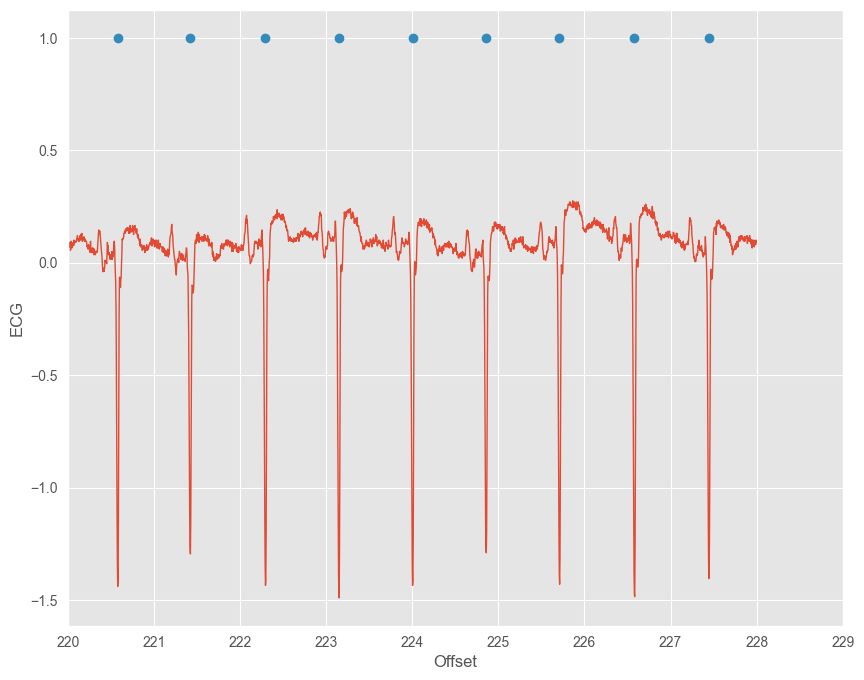

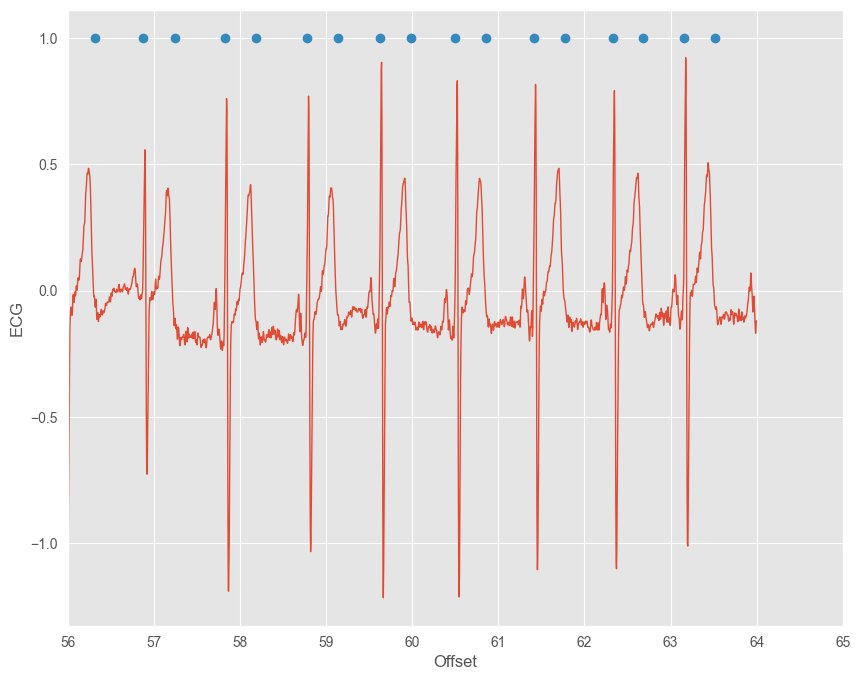

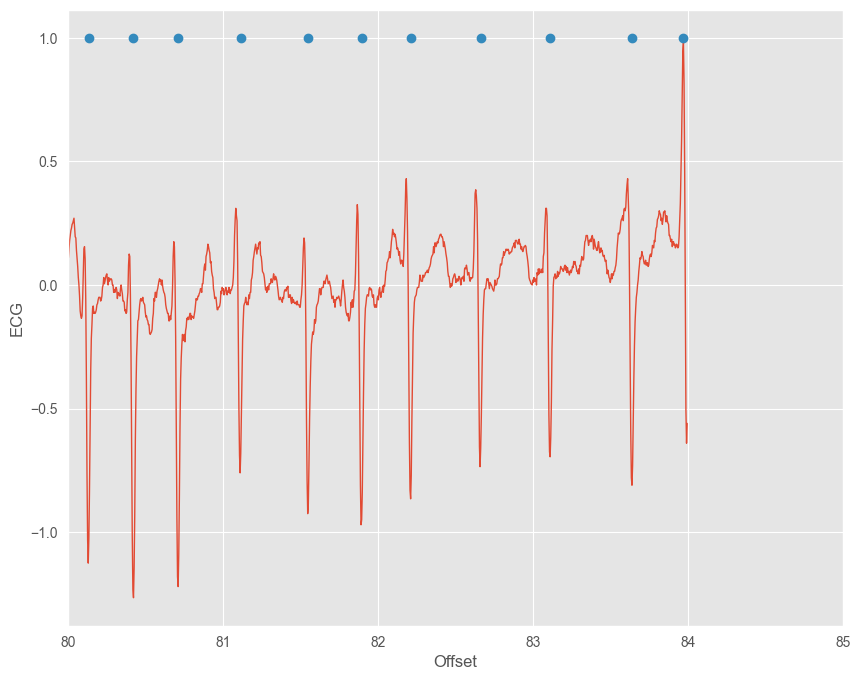

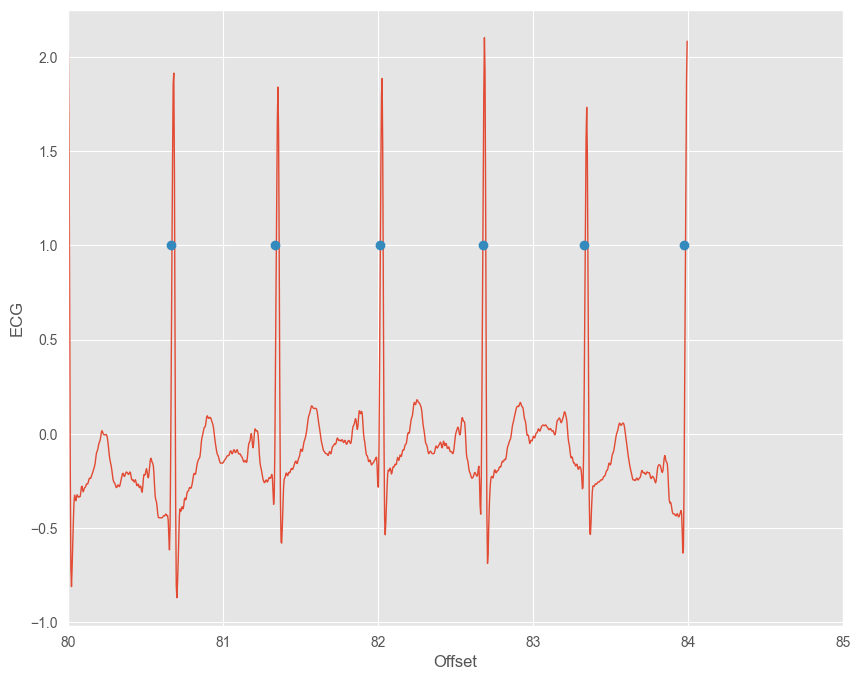

In [15]:

#plot_ecg_ann(afdb_signals[0],r_peaks_afdb[0],20000,21000,250)

#plot_ecg_ann(sinus_signals[0],r_peaks_sinus[0],20000,21000,250)

plot_ecg_ann(afdb_signals[6],r_peaks_afdb[6],55000,57000,250)

plot_ecg_ann(sinus_signals[8],r_peaks_sinus[8],14000,16000,250)

plot_ecg_ann(afdb_signals[3],r_peaks_afdb[3],20000,21000,250)

plot_ecg_ann(sinus_signals[12],r_peaks_sinus[12],20000,21000,250)

## Probability Distributions

In [17]:
def samp2sec(x): 
       
    """
       Changes samples to seconds. 
        
        Parameters
        ----------
        sample : numpy array
            numpy array of single channel ecg from the wfdbdb-records
        
        Returns
        -------
        Sample changed into seconds
    """
    return (x/250)

def rr_intervals(rpeaks):
       
    """
        Calculates RR intervals. 
        
        Parameters
        ----------
        rpeaks : wfdb object
           wfdb annotation object with rpeaks from ecg signal
        
        Returns
        -------
        rr_intervals in seconds, rr_intervals in samples 
    """
    r_peaks=[]
    rr_intervals_sample=[]
    rr_intervals_sec=[]
    for rpeak in rpeaks:

        samp=np.array(rpeak.sample)
        rr_samp=np.diff(samp)
        
        rr_sec=list(map(samp2sec,rr_samp))
        rr_intervals_sec.append(rr_sec)
        rr_intervals_sample.append(rr_samp)
    return rr_intervals_sample,rr_intervals_sec

###### Calculate RR_Intervals of Sinus and AFIB signals

In [18]:
sinus_rr_samp,sinus_rr_sec=rr_intervals(r_peaks_sinus)

afib_rr_samp,afib_rr_sec=rr_intervals(r_peaks_afdb)

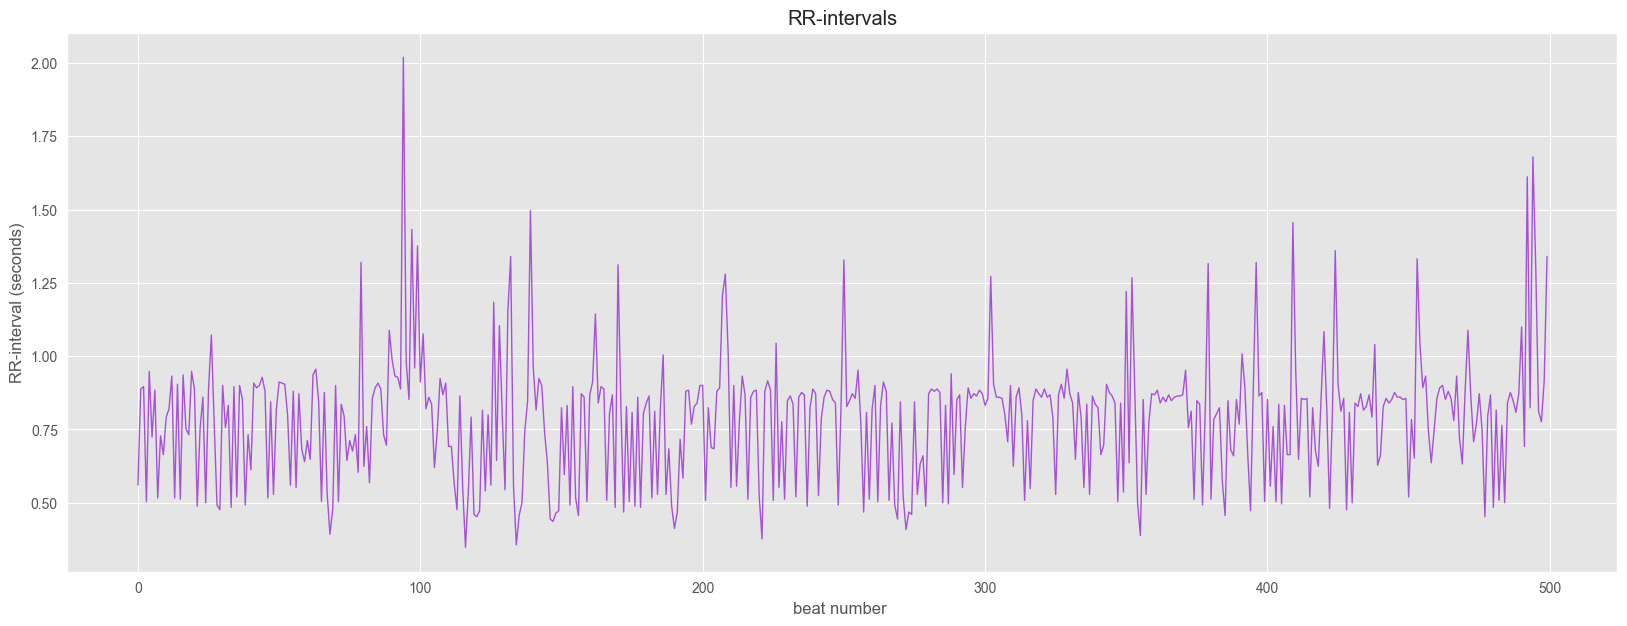

In [19]:
plt.figure(figsize=(20, 7))
plt.title("RR-intervals")
plt.xlabel("beat number ")
plt.ylabel("RR-interval (seconds)")
sample = 6

start=6500
stop=7000
#len(sinus_rr_ms[s])
#t=np.linspace(0, len(ms_dif)/250, len(ms_dif))
plt.plot(afib_rr_sec[sample][start:stop],label="RR-interval", color="#A651D8")

plt.show()

In [21]:
#probability distribution computation. 

def pdf(rr_intervals,title,bs):
     """
       Calculates the PDF or RR_Intervals and plots it. 
        
        Parameters
        ----------
        rr_intervals : numpy array
            numpy array of rr intervals
        title:
            title of the plot
        bs:
            bin size of pdf
        Returns
        -------
        None
    """
    i=0
    print(title)
    for sample in rr_intervals:
        print(i)
        plt.figure(figsize=(10,8))
       
        # N is the count in each bin, bins is the lower-limit of the bin
        
        N, bins, patches = plt.hist(sample, bins=bs,density=True,alpha=0.7)
        
        mu, sigma = norm.fit(sample)
        best_fit_line = norm.pdf(bins, mu, sigma)
        plt.plot(bins, best_fit_line,'--',color='red')

        # fit lognormal distribution
        plt.xlim(0,600)

        # We'll color code by height, but you could use any scalar
        fracs = N / N.max()

        # we need to normalize the data to 0..1 for the full range of the colormap
        normal = colors.Normalize(fracs.min(), fracs.max())

        # Now, we'll loop through our objects and set the color of each accordingly
        for thisfrac, thispatch in zip(fracs, patches):
            color = plt.cm.viridis(normal(thisfrac))
            thispatch.set_facecolor(color)
        plt.show()
        i=i+1
    plt.close('all')

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 19)

###### PDF of Afib Samples

afib_rrs
0


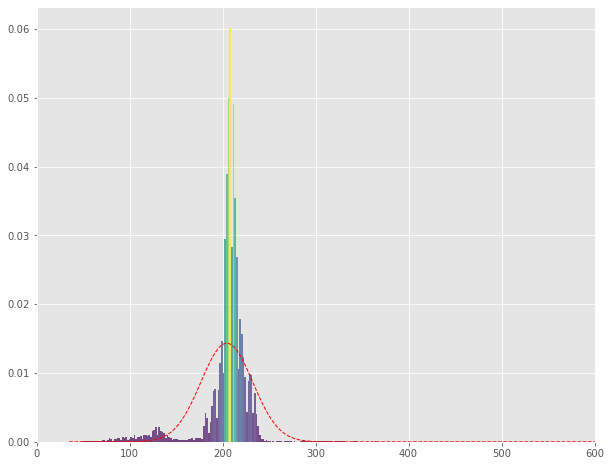

1


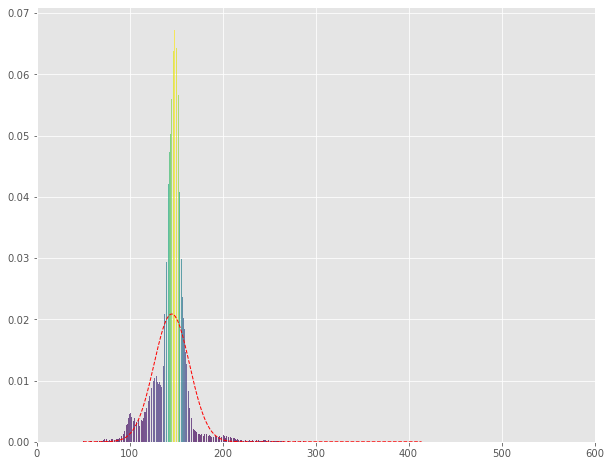

2


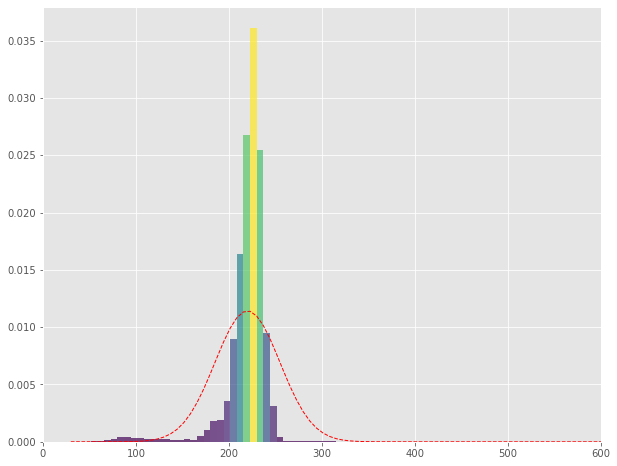

3


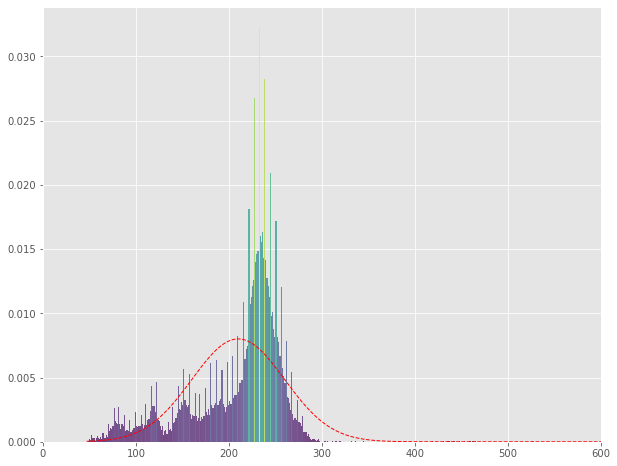

4


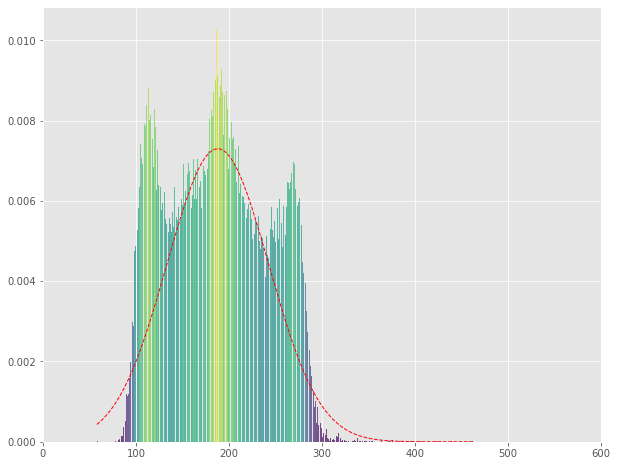

5


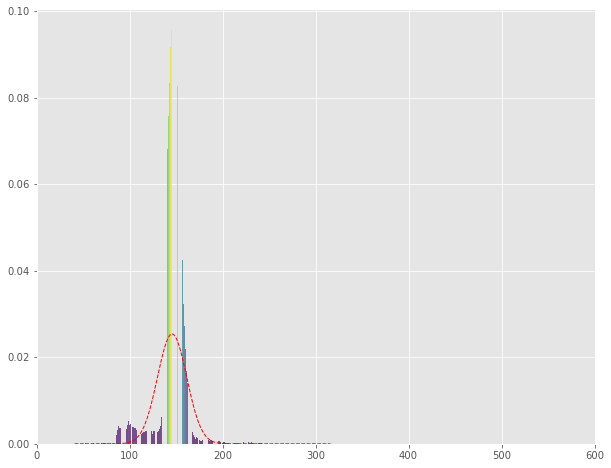

6


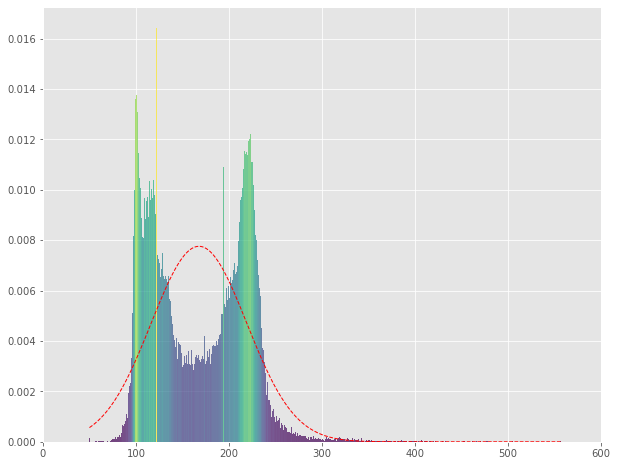

7


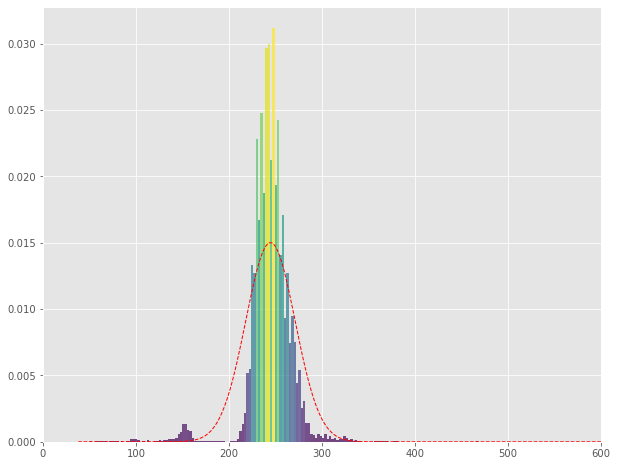

8


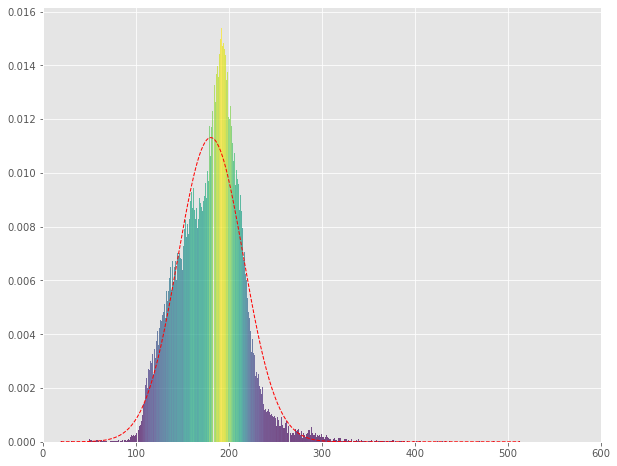

9


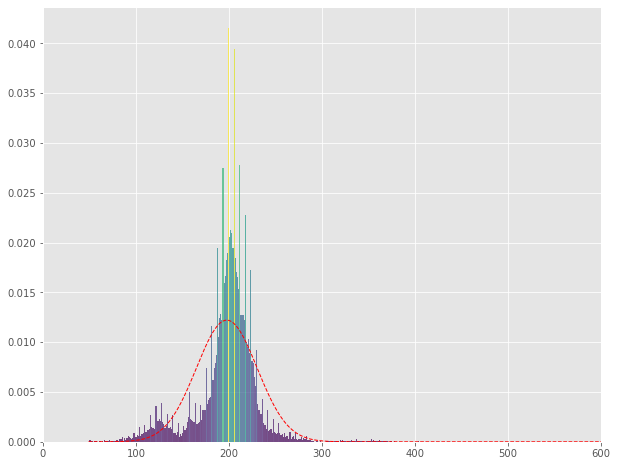

10


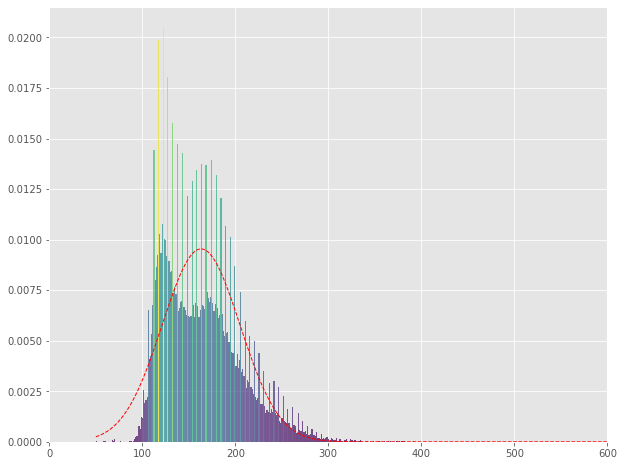

11


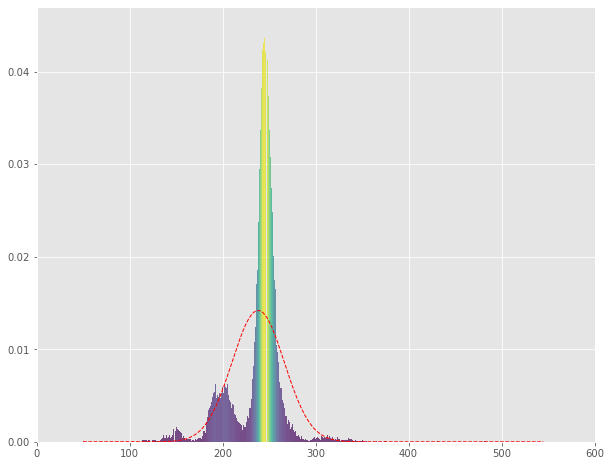

12


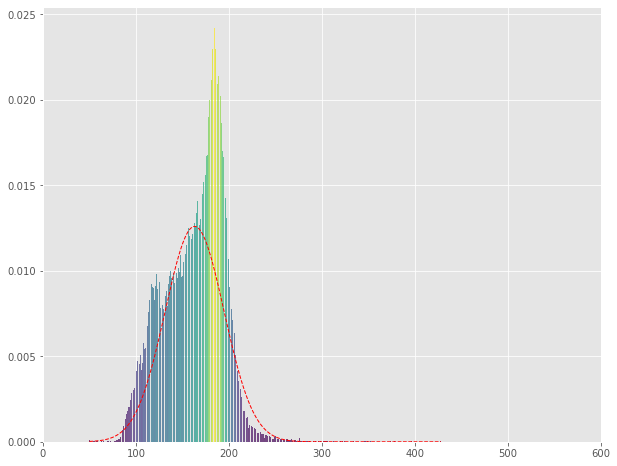

13


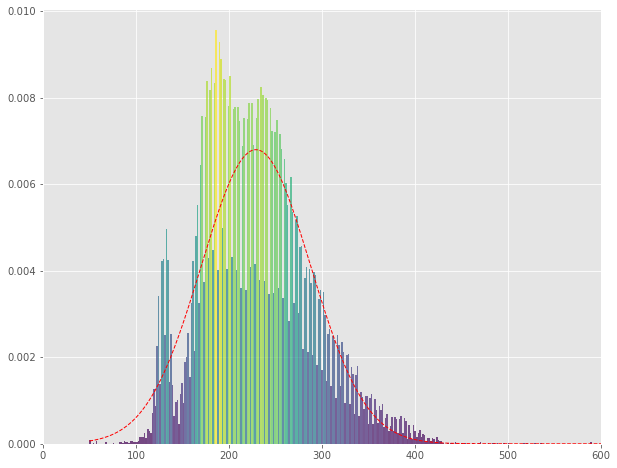

14


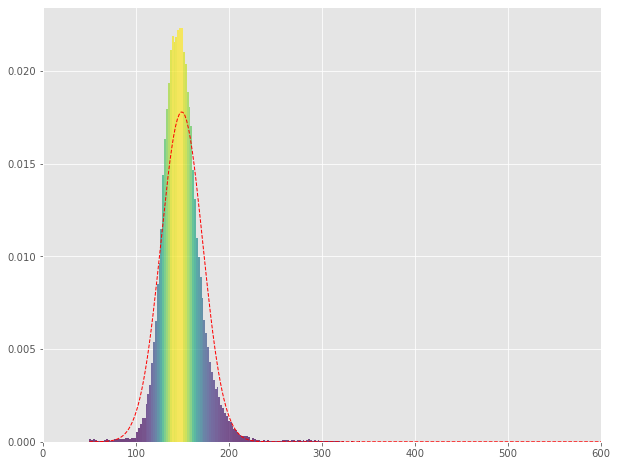

15


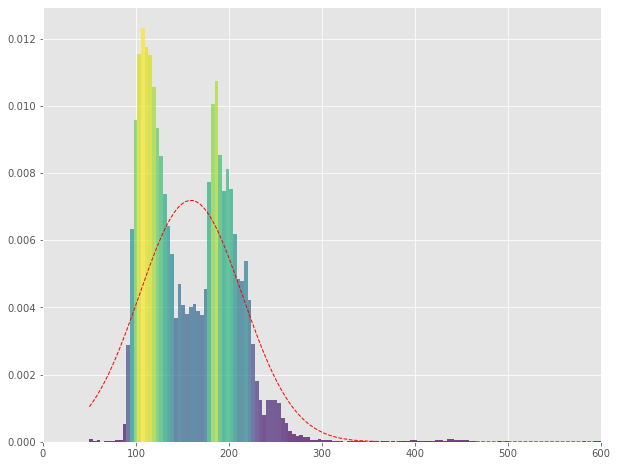

16


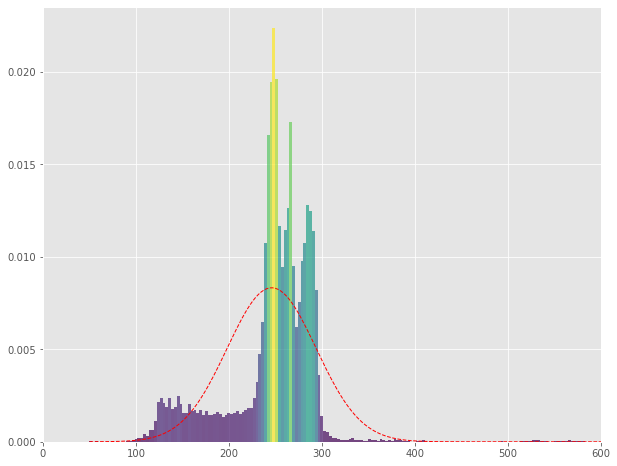

17


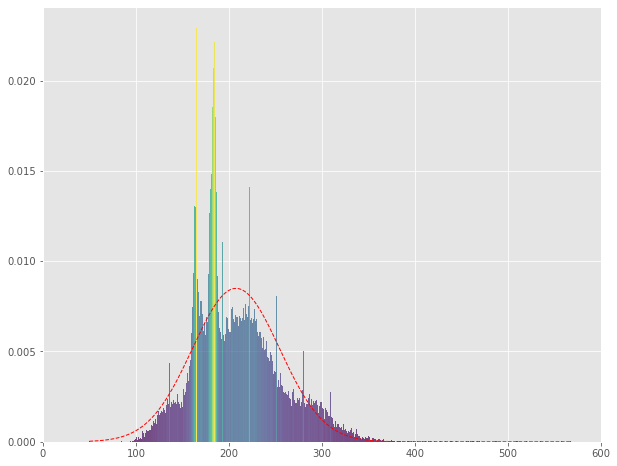

18


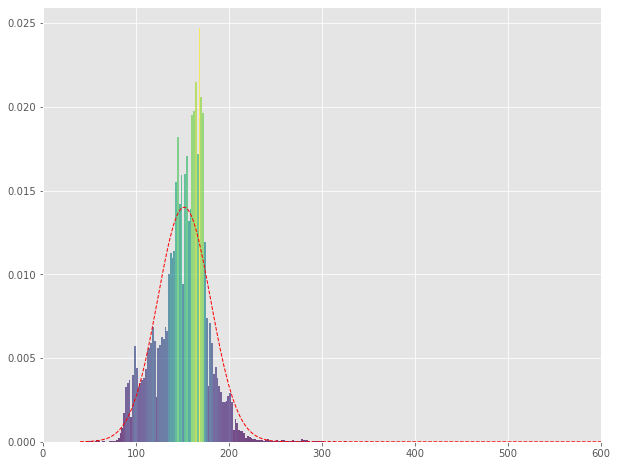

19


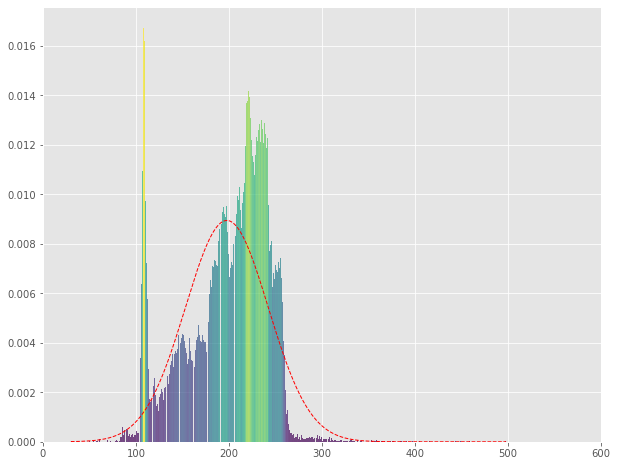

20


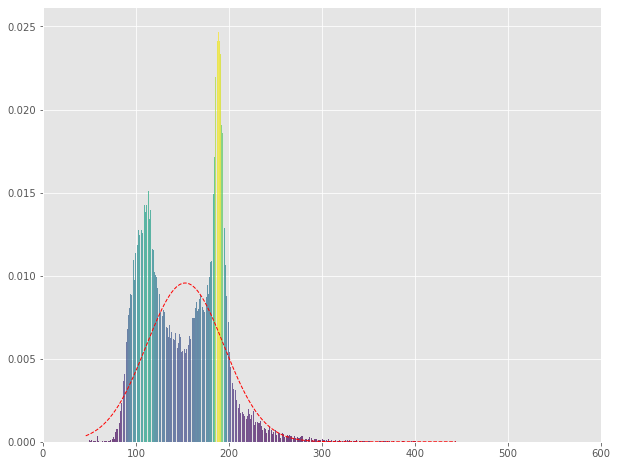

21


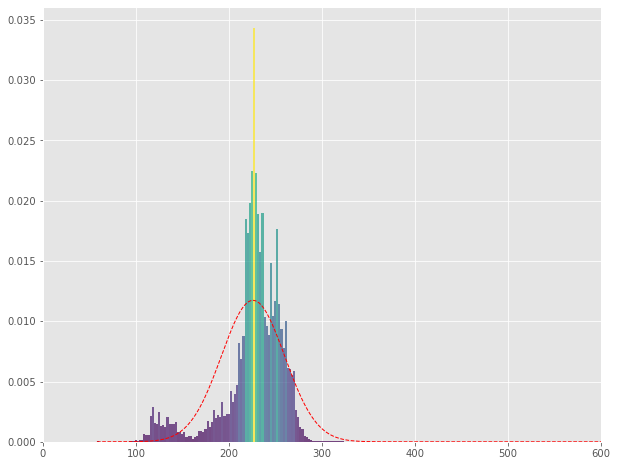

22


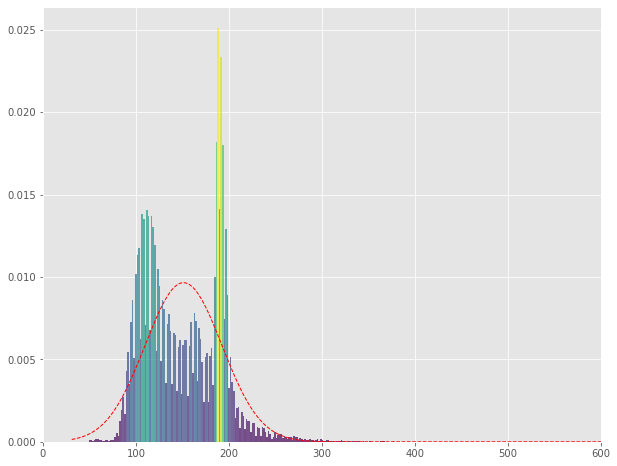

In [14]:
pdf(afib_rr_samp,'afib_rrs',bs=500)

###### PDF of Sinus Samples

sinus_rr
0


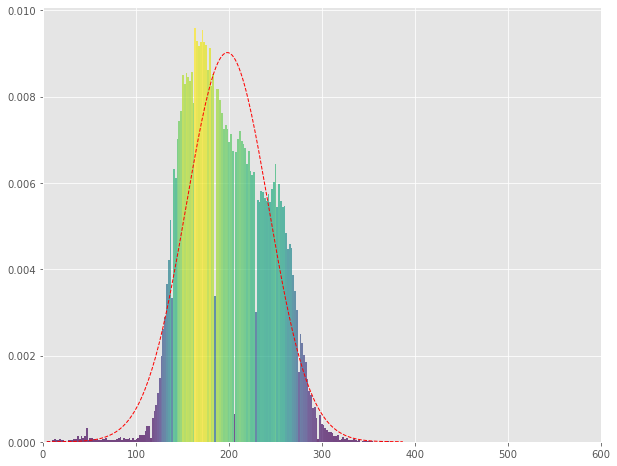

1


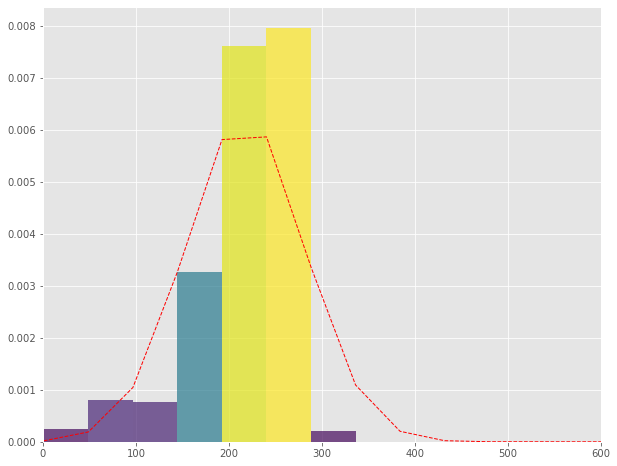

2


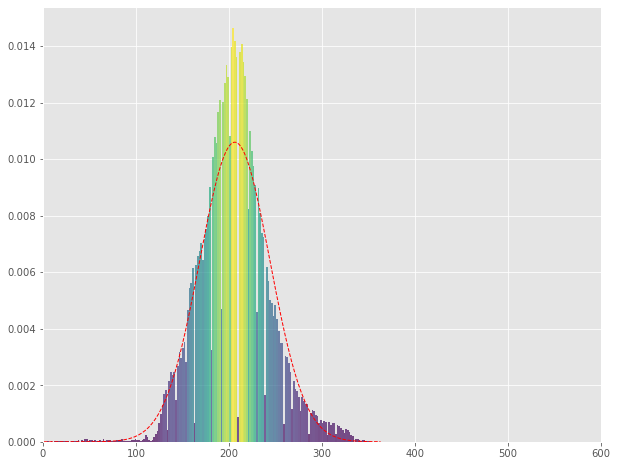

3


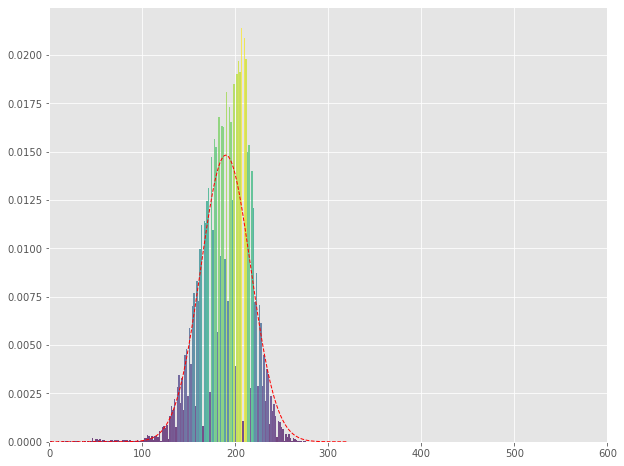

4


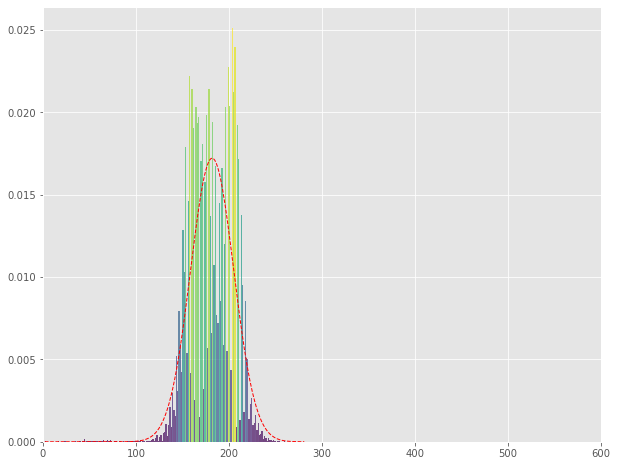

5


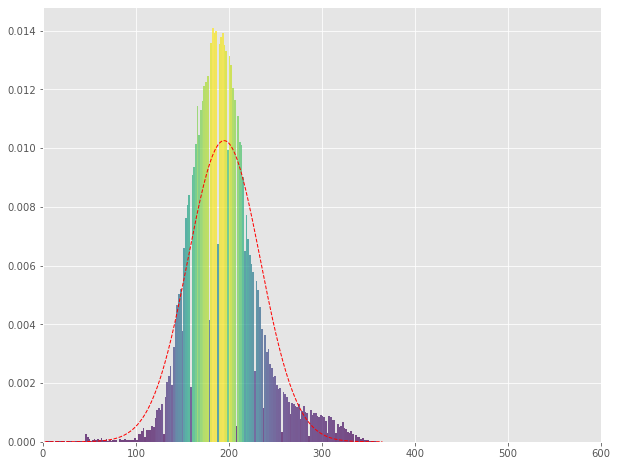

6


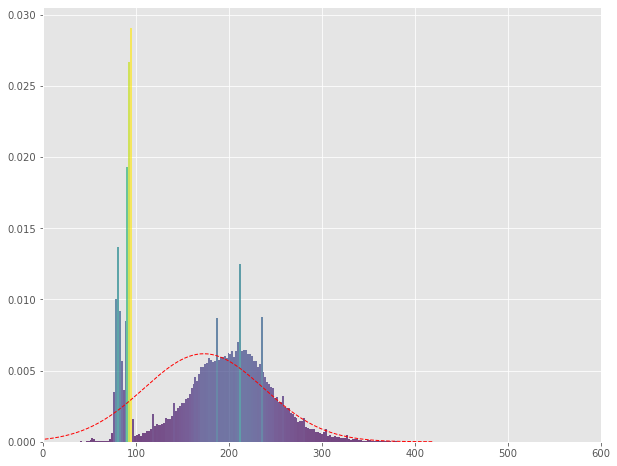

7


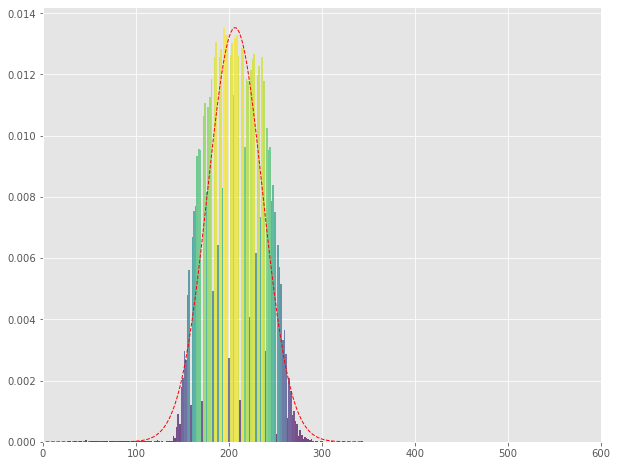

8


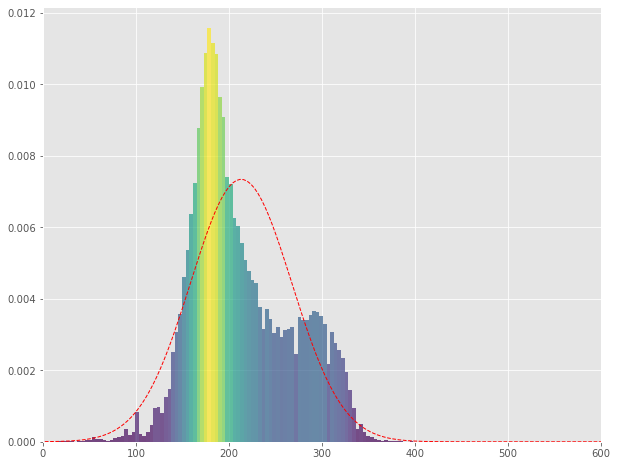

9


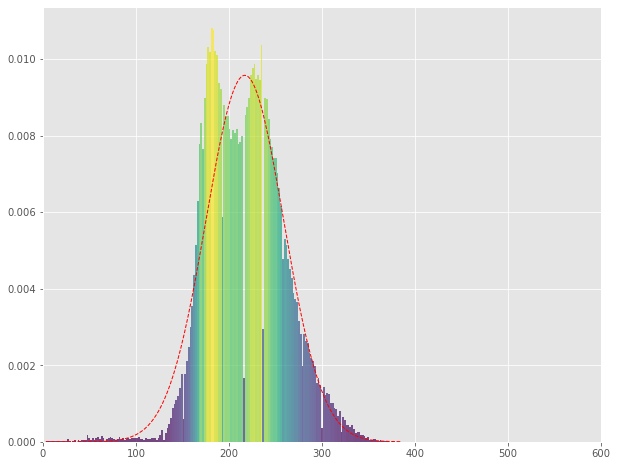

10


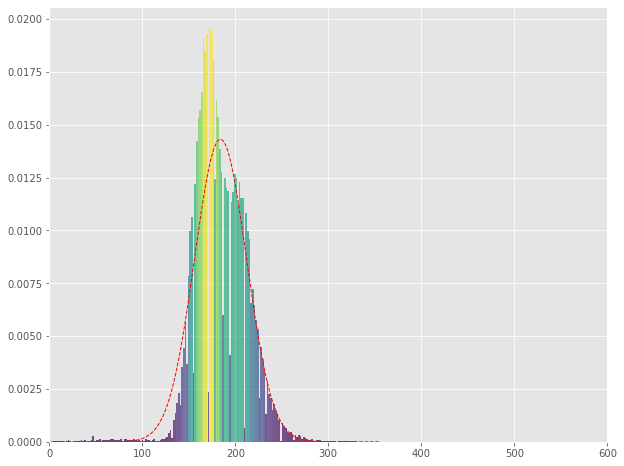

11


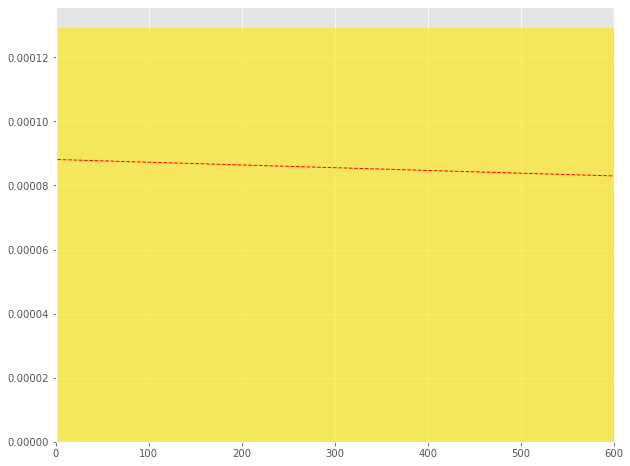

12


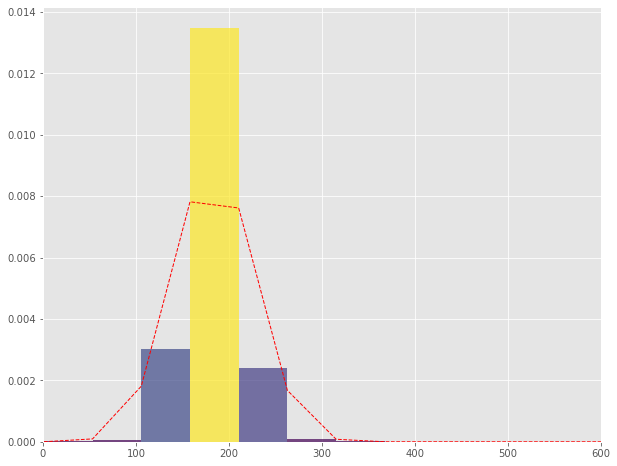

13


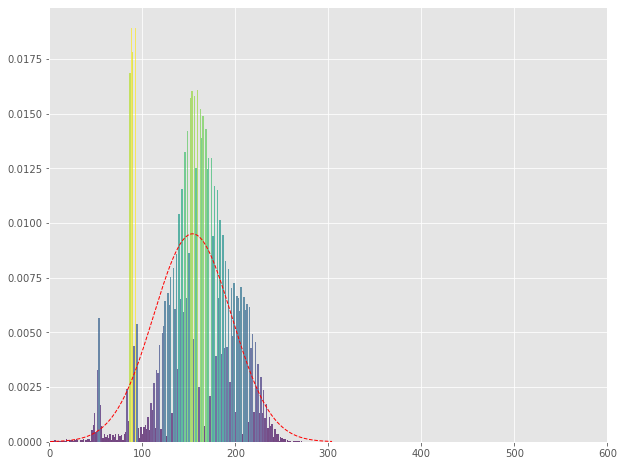

14


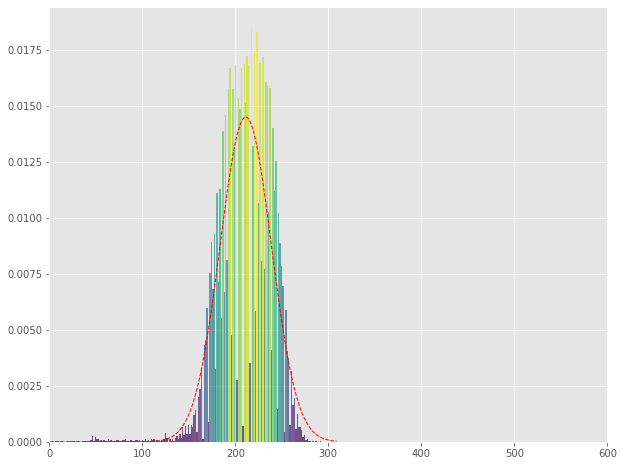

15


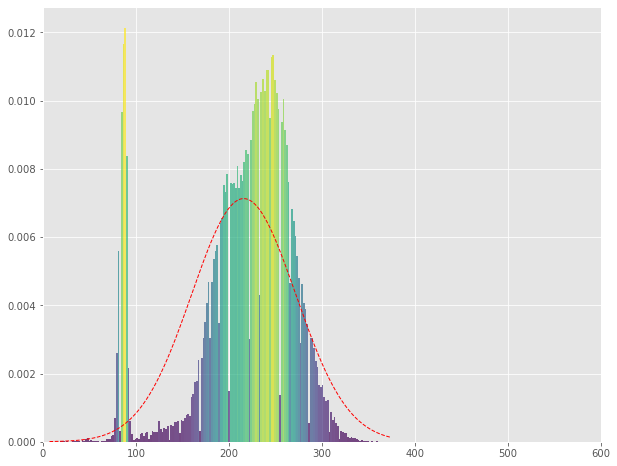

16


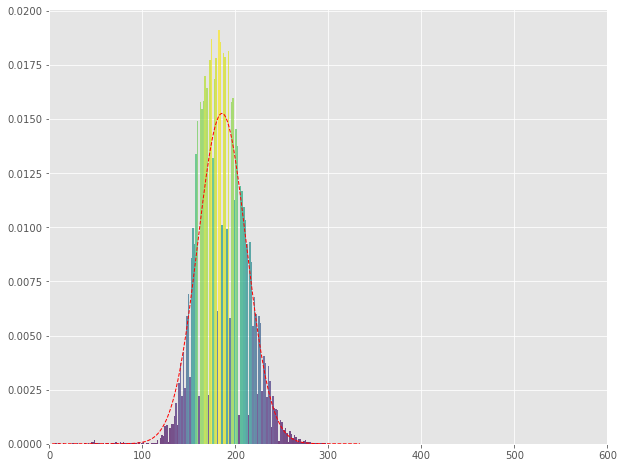

17


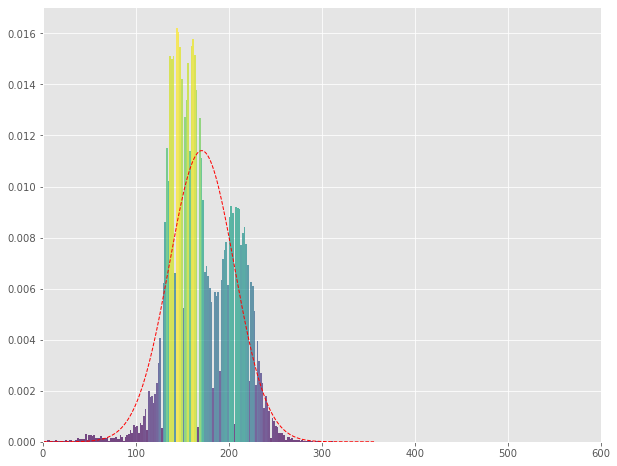

In [15]:
pdf(sinus_rr_samp,'sinus_rr',bs=200)

### Segmentation and Beat Extraction. 

In [24]:
import random

def extract_beats(sig,rpeaks,back,forward,N):
    """
       Extracts the beats from the signal randomly. 
        
            Parameters
            ----------
            sig : sample
                numpy array of single channel ecg from the wfdbdb-records
            rpeaks:
                rpeaks of sig 
            back: 
                beat starting point
            forward:
                beat ending point
            N:
                number of beats to extract
            Returns
            -------
            beats, number of beats extracted
    """
    rpeaks=rpeaks.sample
    random_idx = []
    beats=[]
    for i in range(0,N):
        n = random.randint(1,len(rpeaks))
        random_idx.append(n)
    #print(random_idx)
    for j in random_idx:
        beat_start=rpeaks[j]-back
        beat_end=rpeaks[j]+forward
        
        beat=sig[beat_start:beat_end]
        beats.append(beat)
    return beats,N

In [25]:
def plot_beats(sample,N):
    """
        Plots the beats. 
        
            Parameters
            ----------
            sample : numpy array
                numpy array of single channel ecg from the wfdbdb-records
            N:
                number of extracted beats per sample
            Returns
            -------
            None
    """
    if (N >1):
        fig, ax = plt.subplots(len(sample), N, figsize=(8,20),sharex=True)

        for beat in range(len(sample)):
            for x in range(0,N):

                ax[beat,x].plot(sample[beat][x])
    else:
        fig, ax = plt.subplots(len(sample), N, figsize=(5,20),sharex=True)

        for beat in range(len(sample)):
            

                ax[beat].plot(sample[beat][0])

##### In normal sinus rhytms almost all the signal looks same except for few beats that have noise. More or less all the signal looks same so beats from Normal Sinus Ryhtms were taken randomly. The visualisation of samples can be done through this link https://physionet.org/lightwave/?db=nsrdb/1.0.0 


In [445]:
sinus_beats_temp=[]
for sample in range(len(sinus_signals)):
    beat,N=extract_beats(sinus_signals[sample],r_peaks_sinus[sample],125,125,N=1)
    sinus_beats_temp.append(beat)
    
plot_beats(sinus_beats_temp,N)




ValueError: Number of rows must be a positive integer, not 0

<Figure size 360x1440 with 0 Axes>